<a href="https://colab.research.google.com/github/ioqfwfq/NMA_DL2021_Project/blob/main/NMA_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Setup

In [2]:
# Imports
import torch
import numpy as np
import sklearn.decomposition
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import scipy.stats as stats
from matplotlib import pyplot as plt

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Note:** If `cuda` is not enabled, go to `Runtime`--> `Change runtime type` and in `Hardware acceleration` choose `GPU`. 

---
# Load Data from Google Drive


In [4]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/Colab\ Notebooks/data/
!pwd
!dir

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/17xuhq9TF8GNhT9Xklt08_1TwyLvMiN_6/data
/content/drive/.shortcut-targets-by-id/17xuhq9TF8GNhT9Xklt08_1TwyLvMiN_6/data
mouse1_day1_suqare1.csv  mouse1_day1_suqare2.mat  mouse1_day7_suqare1.csv
mouse1_day1_suqare1.mat  mouse1_day4_suqare1.csv  mouse1_day7_suqare1.mat
mouse1_day1_suqare2.csv  mouse1_day4_suqare1.mat  ReadMe.txt


In [5]:
fn = 'mouse1_day1_suqare2.csv'
data = pd.read_csv(fn, index_col=0)

---
# test

In [6]:
prodata = data.iloc[:,0:-3].values
prodata.shape

(5758, 471)

# Heatmap

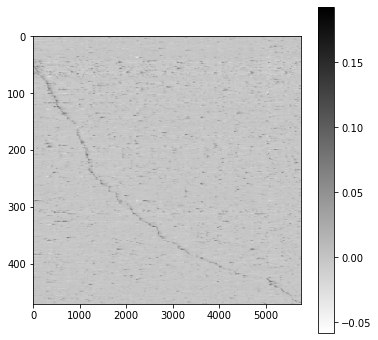

In [7]:
plt.figure(figsize=(6, 6))
plt.imshow(prodata.T, cmap='gray_r', aspect=prodata.shape[0]/prodata.shape[1])
plt.colorbar()

# Behavioral

In [8]:
#@title Transform and normalize the coordinates

behdata = data.iloc[:,-3:].values
x_coo = behdata[:,0]
y_coo = behdata[:,1]
x_len = x_coo.max()-x_coo.min()
y_len = y_coo.max()-y_coo.min()
x_cen = (x_coo.max()+x_coo.min())*0.5
y_cen = (y_coo.max()+y_coo.min())*0.5

x_coo_nor = (x_coo-x_cen)/(x_len*0.5) # range [-1, 1]
y_coo_nor = (y_coo-y_cen)/(y_len*0.5) # range [-1, 1]

loc_cl = np.zeros_like(x_coo_nor)
for i in range(5):
  if x_coo_nor[i]>0 and y_coo_nor[i]>0:
    loc_cl[i] = 1
  if x_coo_nor[i]<0 and y_coo_nor[i]>0:
    loc_cl[i] = 2
  if x_coo_nor[i]<0 and y_coo_nor[i]<0:
    loc_cl[i] = 3
  if x_coo_nor[i]>0 and y_coo_nor[i]<0:
    loc_cl[i] = 4

loc_cl.shape

(5758,)

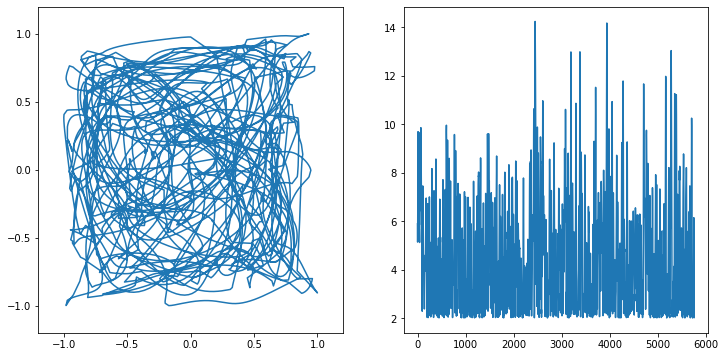

In [9]:
#@title Plot the trace
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(x_coo_nor,y_coo_nor)
plt.ylim([-1.2,1.2])
plt.xlim([-1.2,1.2])

plt.subplot(122)
plt.plot(behdata[:,2])

# PCA

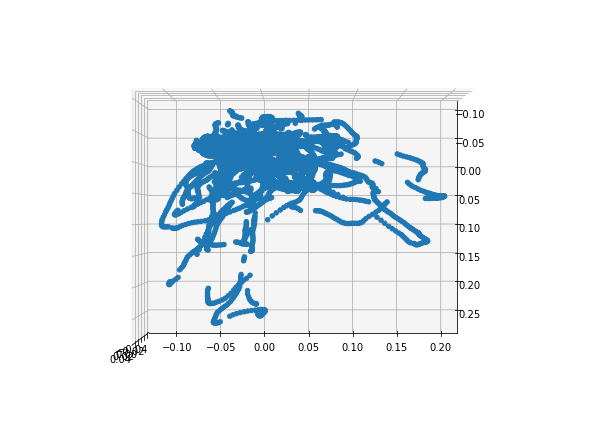

In [18]:
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D

X = prodata
y = loc_cl


fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=90, azim=0)

plt.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X = pca.transform(X)

ax.scatter(X[:, 0], X[:, 1])

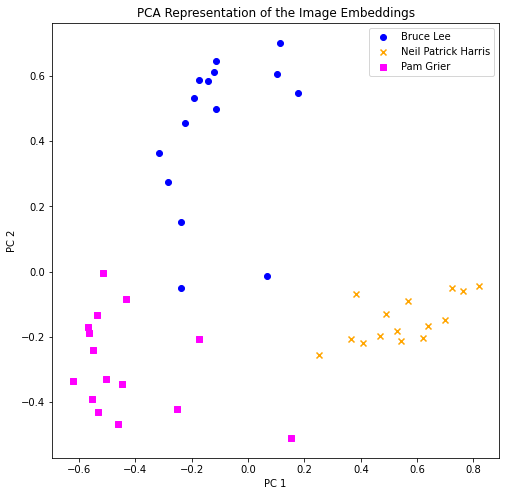

In [ ]:
embedding_tensor = torch.cat((bruce_embeddings,
                              neil_embeddings,
                              pam_embeddings)).to(device='cpu')

pca = sklearn.decomposition.PCA(n_components=2)
pca_tensor = pca.fit_transform(embedding_tensor.detach().cpu().numpy())

num = 15
categs = 3
colors = ['blue', 'orange', 'magenta']
labels = ['Bruce Lee', 'Neil Patrick Harris', 'Pam Grier']
markers = ['o', 'x', 's']
plt.figure(figsize=(8, 8))
for i in range(categs):
   plt.scatter(pca_tensor[i*num:(i+1)*num, 0],
               pca_tensor[i*num:(i+1)*num, 1],
               c=colors[i],
               marker=markers[i], label=labels[i])
plt.legend()
plt.title('PCA Representation of the Image Embeddings')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

---
# Simulate some data from a linear dynamical system

In [ ]:
# set the seed
np.random.seed(42)

# 100 trials is typical of neural data
ntrials = 100

# we simulate 200 neurons
NN = 400

# we will pretend like every "bin" is 10ms, so the trial length is 2500ms
NT = 250

# let's use 10 latent components
ncomp = 10

# this is the recurrent dynamics matrix, which we made diagonal for simplicity
# values have to be smaller than 1 for stability
A0 =  np.diag(.8 + .2 * np.random.rand(ncomp,))

# this is the projection matrix from components to neurons
C0 = .025 * np.random.randn(ncomp, NN)

# We generate the dynamics of the low-d system. We initialize the latent state.

# start by initializing the latents
y       = 2 * np.random.randn(ncomp)
latents = np.zeros((NT, ntrials, ncomp))
# we run the dynamics forward and add noise (or "innovations") at each timestep
for t in range(NT):
  y = y @ A0 +  np.random.randn(ntrials, ncomp)
  latents[t] = y

# we now project the latents to the neuron space and threshold to generate firing rates
rates = np.maximum(0, latents @ C0)

# now we draw poisson counts to simulate the number of spikes a neuron fires randomly
x = np.random.poisson(rates)

In [ ]:
x.shape

(250, 100, 400)

---
#  Define RNN

In [ ]:
class Net(nn.Module):
  def __init__(self, ncomp, NN1, NN2, bidi=True):
    super(Net, self).__init__()

    # play with some of the options in the RNN!
    self.rnn = nn.RNN(NN1, ncomp, num_layers = 1, dropout = 0,
                      bidirectional = bidi, nonlinearity = 'tanh')
    self.fc = nn.Linear(ncomp, NN2)

  def forward(self, x):

    y = self.rnn(x)[0]

    if self.rnn.bidirectional:
      # if the rnn is bidirectional, it concatenates the activations from the forward and backward pass
      # we want to add them instead, so as to enforce the latents to match between the forward and backward pass
      q = (y[:, :, :ncomp] + y[:, :, ncomp:])/2
    else:
      q = y

    # the softplus function is just like a relu but it's smoothed out so we can't predict 0
    # if we predict 0 and there was a spike, that's an instant Inf in the Poisson log-likelihood which leads to failure
    z = F.softplus(self.fc(q), 10)

    return z, q

---
# Prepare data

In [ ]:
cdata = prodata.reshape([prodata.shape[0],1,prodata.shape[1]])
cdata = cdata[0:-1:30,:,:]
cdata.shape

(259, 1, 505)

In [ ]:
# we separate the neuron data into two populations: the input and output
x0 = torch.from_numpy(cdata[:, :, :200]).to(device).float()
x1 = torch.from_numpy(cdata[:, :, 200:400]).to(device).float()

NN1 = x1.shape[-1]
NN2 = x0.shape[-1]

# we initialize the neural network
net = Net(ncomp, NN1, NN2, bidi = True).to(device)

# special thing:  we initialize the biases of the last layer in the neural network
# we set them as the mean firing rates of the neurons.
# this should make the initial predictions close to the mean, because the latents don't contribute much
net.fc.bias.data[:] = x1.mean((0,1))

# we set up the optimizer. Adjust the learning rate if the training is slow or if it explodes.
optimizer = torch.optim.Adam(net.parameters(), lr=.005)

---
# Train the RNN

In [ ]:
# you can keep re-running this cell if you think the cost might decrease further

# we define the Poisson log-likelihood loss
def Poisson_loss(lam, spk):
  return lam - spk * torch.log(lam)

niter = 1000
for k in range(niter):
  # the network outputs the single-neuron prediction and the latents
  z, y = net(x1)

  # our log-likelihood cost
  cost = Poisson_loss(z, x0).mean()

  # train the network as usual
  cost.backward()
  optimizer.step()
  optimizer.zero_grad()

  if k % 100 == 0:
    print(f'iteration {k}, cost {cost.item():.4f}')

iteration 0, cost 0.0784
iteration 100, cost -0.0096
iteration 200, cost nan
iteration 300, cost nan
iteration 400, cost nan
iteration 500, cost nan
iteration 600, cost nan
iteration 700, cost nan
iteration 800, cost nan
iteration 900, cost nan


---
# Compare true firing rates with the predicted.

Note that for real data we only get the spikes, not the true firing rates! 

In [ ]:
z.detach().cpu().numpy()

array([[[nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)

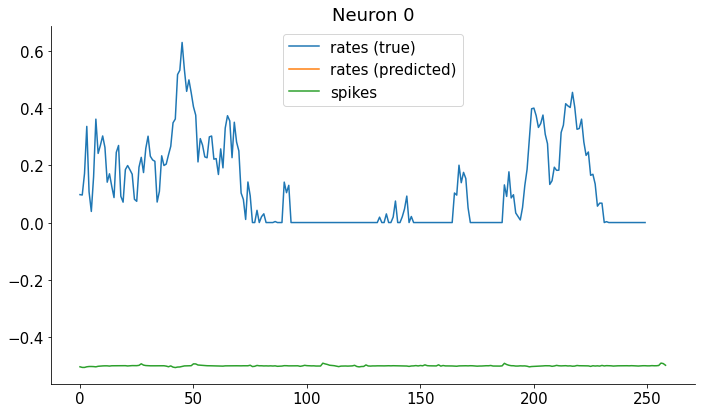

In [ ]:
rpred = z.detach().cpu().numpy()

nn = 0
plt.figure(figsize=(10, 6))
plt.plot(rates[:,nn, 0])
plt.plot(rpred[:,nn, 0])
plt.plot(-.5 + cdata[:, nn, 0]/4)

plt.legend(['rates (true)', 'rates (predicted)', 'spikes'])
plt.title(f'Neuron {nn}')
plt.show()

## View firing rates for all neurons in one trial

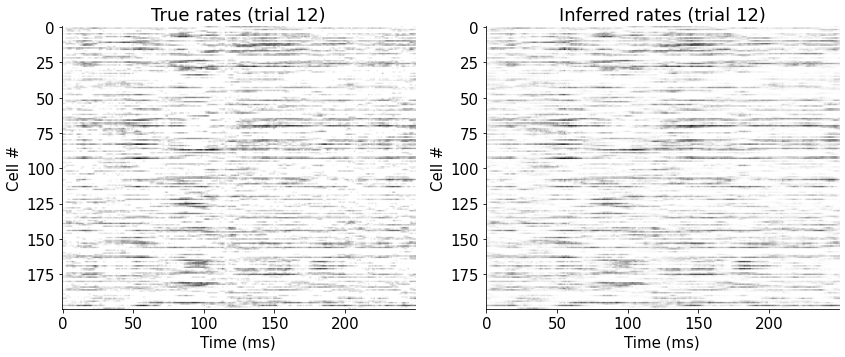

In [ ]:
plt.figure(figsize = (12, 8))
plt.subplot(121)
plt.imshow(rates[:, 12, :200].T, cmap='gray_r')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.title('True rates (trial 12)')

plt.subplot(122)
plt.imshow(rpred[:, 12, :].T, cmap='gray_r')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.title('Inferred rates (trial 12)')
plt.show()

---
# Visualize the latent dynamics

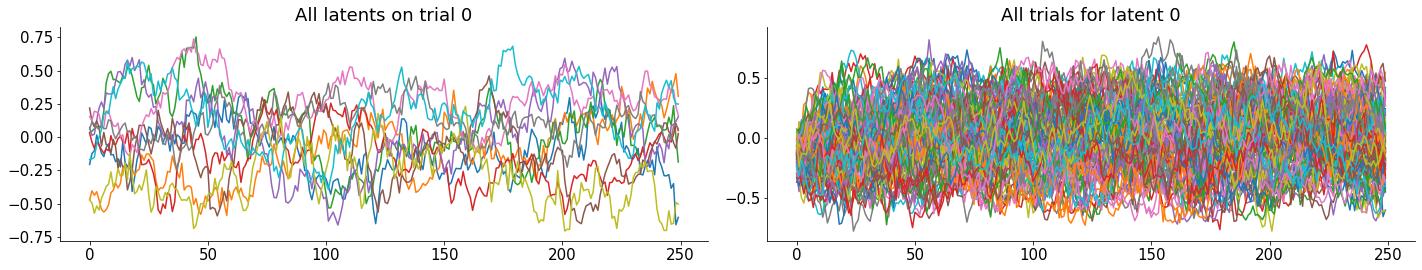

In [ ]:
ycpu = y.detach().cpu().numpy()

plt.figure(figsize=(20, 4))
plt.subplot(121)
plt.plot(ycpu[:, 0, :]);
plt.title('All latents on trial 0')

plt.subplot(122)
plt.plot(ycpu[:, :, 0]);
plt.title('All trials for latent 0')
plt.show()

Not much to see for the latents. This is not surprising, since we generated them with random data, so they look just like a random walk process. 

Now apply this model on real data and see if you can interpret the latents. 

